Outlines the approach we will be taking to identify which of the 1000 customers Sprocket Central Pty Ltd should target, based on this dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

In [3]:
#read excel file
df= pd.ExcelFile("KPMG_VI_New_raw_data_update_final.xlsx")

In [4]:
#Read excel sheet seperate
Transactions = pd.read_excel(df, 'Transactions')
NewCustomerList = pd.read_excel(df, 'NewCustomerList')
CustomerDemographic = pd.read_excel(df, 'CustomerDemographic')
CustomerAddress = pd.read_excel(df, 'CustomerAddress')

C:\Users\Lagartha Lothbroke\AppData\Local\Temp/ipykernel_17124/3544616722.py:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  NewCustomerList = pd.read_excel(df, 'NewCustomerList')
C:\Users\Lagartha Lothbroke\AppData\Local\Temp/ipykernel_17124/3544616722.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  CustomerDemographic = pd.read_excel(df, 'CustomerDemographic')


In [6]:
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [8]:
CustomerDemographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [9]:
#drop insignificant variable
CustomerDemographic.drop(['first_name', 'last_name', 'default', 'job_title'], axis=1, inplace=True)

In [10]:
CustomerDemographic.drop('deceased_indicator', axis=1, inplace=True)

In [11]:
#Re-naming the categories
CustomerDemographic['gender'] = CustomerDemographic['gender'].replace('F','Female').replace('M','Male').replace('Femal','Female')

In [14]:
#Drop null
CustomerDemographic = CustomerDemographic.dropna(axis=1, how='all')
CustomerDemographic = CustomerDemographic.dropna()

In [18]:
#creating age column
import datetime as dt
CustomerDemographic['age'] = (dt.datetime.now() - CustomerDemographic['DOB']) / np.timedelta64(1, 'Y')
CustomerDemographic['age_class'] = ((round(CustomerDemographic['age'] / 10)) * 10).astype(int)


In [19]:
CustomerDemographic.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class
0,1,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,69.591185,70
1,2,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,42.411983,40
2,3,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0,69.317395,70
3,4,Male,33,1961-10-03,IT,Mass Customer,No,7.0,61.615662,60
5,6,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,56.662788,60


In [20]:
CustomerAddress = CustomerAddress.dropna()

CustomerAddress['state'].replace('New South Wales', 'NSW', inplace=True)
CustomerAddress['state'].replace('Victoria', 'VIC', inplace=True)

In [21]:
df_demo_add = pd.merge(CustomerDemographic, CustomerAddress, left_index=True, right_index=True)
df_demo_add= df_demo_add.dropna()
df_demo_add.head()

,customer_id_x,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class,customer_id_y,address,postcode,state,country,property_valuation
0,1,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,69.591185,70,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,42.411983,40,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,3,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0,69.317395,70,4,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Male,33,1961-10-03,IT,Mass Customer,No,7.0,61.615662,60,5,17979 Del Mar Point,2448,NSW,Australia,4
5,6,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,56.662788,60,7,4 Delaware Trail,2210,NSW,Australia,9


In [22]:
Transactions = Transactions.sort_values('customer_id')

In [23]:
Transactions = Transactions.dropna(axis=1, how='all')
Transactions = Transactions.dropna()

In [24]:
Transactions.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [25]:
Transactions['columnsoduct_first_sold_date'] = pd.TimedeltaIndex(Transactions['product_first_sold_date'], unit='d') + dt.datetime(1900,1,1)
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,columnsoduct_first_sold_date
14485,14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,33455.0,1991-08-07
18969,18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,35378.0,1996-11-11
16422,16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,37838.0,2003-08-07
5156,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0,2003-07-23
13423,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0,2005-08-11


In [26]:
Transactions['transaction_date'].describe(datetime_is_numeric=True)

count                            19445
mean     2017-07-01 16:21:18.189766144
min                2017-01-01 00:00:00
25%                2017-04-01 00:00:00
50%                2017-07-03 00:00:00
75%                2017-10-02 00:00:00
max                2017-12-30 00:00:00
Name: transaction_date, dtype: object

In [27]:
most_recent_purchase = Transactions['transaction_date'].max()
Transactions['last_purchase_days_ago'] = most_recent_purchase - Transactions['transaction_date']
Transactions['last_purchase_days_ago'] /= np.timedelta64(1, 'D')
Transactions['profit'] = Transactions['list_price'] - Transactions['standard_cost']
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,columnsoduct_first_sold_date,last_purchase_days_ago,profit
14485,14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,33455.0,1991-08-07,278.0,75.75
18969,18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,35378.0,1996-11-11,276.0,509.97
16422,16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,37838.0,2003-08-07,21.0,75.14
5156,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0,2003-07-23,233.0,189.28
13423,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0,2005-08-11,312.0,17.87


In [28]:
customer_data = Transactions.groupby('customer_id').agg({
    'customer_id' : lambda x:x,
    'last_purchase_days_ago': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'profit': lambda x: x.sum()
})

In [29]:
customer_data.rename(columns={
    'last_purchase_days_ago': 'recency', 
    'customer_id': 'frequency', 
    'profit': 'monetary_value'
    }, inplace=True)

In [30]:
customer_data.head()

,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.09
2,3,128.0,2226.26
3,7,102.0,3290.21
4,2,195.0,220.57
5,6,16.0,2394.94


C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


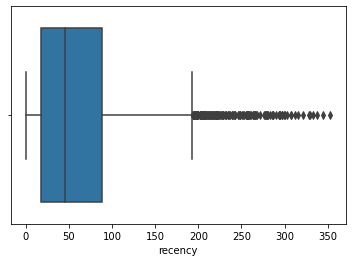

In [31]:
# outlier treatment for recency
sns.boxplot(customer_data['recency'])

q1 = customer_data.recency.quantile(0.25)
q3 = customer_data.recency.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.recency >= q1 - 1.5*iqr) & (customer_data.recency <= q3 + 1.5*iqr)]

C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.090000
2,3,128.0,2226.260000
3,7,102.0,3290.210000
5,6,16.0,2394.940000
6,5,64.0,3946.550000
...,...,...,...
3497,3,52.0,1648.320000
3498,6,127.0,3147.330000
3499,7,51.0,4955.250000


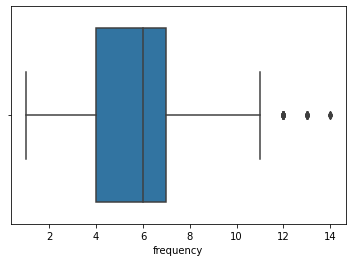

In [32]:
# outlier treatment for frequency

sns.boxplot(customer_data['frequency'])

q1 = customer_data.frequency.quantile(0.25)
q3 = customer_data.frequency.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.frequency >= q1 - 1.5*iqr) & (customer_data.frequency <= q3 + 1.5*iqr)]

customer_data

In [33]:
# outlier treatment for monetary
q1 = customer_data.monetary_value.quantile(0.25)
q3 = customer_data.monetary_value.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.monetary_value >= q1 - 1.5*iqr) & (customer_data.monetary_value <= q3 + 1.5*iqr)]

customer_data

,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.090000
2,3,128.0,2226.260000
3,7,102.0,3290.210000
5,6,16.0,2394.940000
6,5,64.0,3946.550000
...,...,...,...
3497,3,52.0,1648.320000
3498,6,127.0,3147.330000
3499,7,51.0,4955.250000


C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

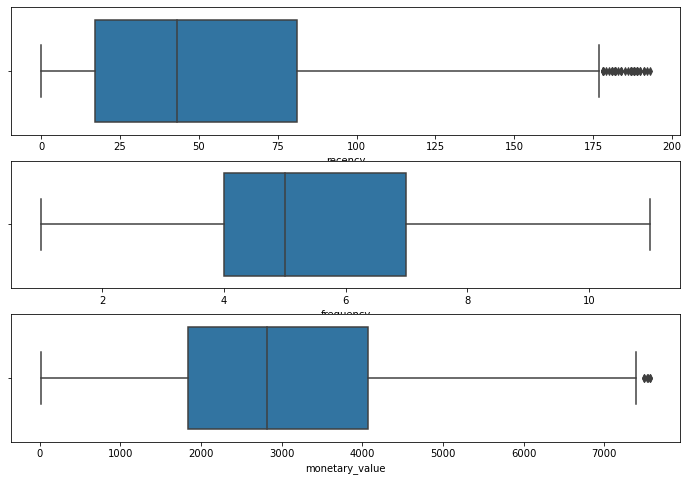

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(12,8))

sns.boxplot(customer_data['recency'], ax= ax[0] )
sns.boxplot(customer_data['frequency'], ax=ax[1] )
sns.boxplot(customer_data['monetary_value'], ax=ax[2])
plt.show()

In [36]:
#standardise the data set

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
customer_data.loc[:, 'recency'] = ss.fit_transform(customer_data[['recency']])
customer_data.loc[:, 'frequency'] = ss.fit_transform(customer_data[['frequency']])
customer_data.loc[:, 'monetary_value'] = ss.fit_transform(customer_data[['monetary_value']])


C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [37]:
RFM = customer_data.copy()
RFM

,frequency,recency,monetary_value
customer_id,,,
1,2.567054,-1.043368,-0.004556
2,-1.214537,1.586116,-0.506816
3,0.676258,1.021103,0.168050
5,0.203559,-0.847786,-0.399822
6,-0.269139,0.195315,0.584368
...,...,...,...
3497,-1.214537,-0.065461,-0.873404
3498,0.203559,1.564384,0.077421
3499,0.676258,-0.087192,1.224189


In [38]:
# create elbow curve and find optimal number of clusters
cluster_error = []

for num_clusters in range(1,15):
    clusters = KMeans(n_clusters=num_clusters, n_init=10)
    clusters.fit(RFM)
    cluster_error.append(clusters.inertia_)
    labels = clusters.labels_
    centroid = clusters.cluster_centers_

clusters_df = pd.DataFrame({'num_of_clusters': (range(1,15)), 'Cluster_errors' : cluster_error})
clusters_df

,num_of_clusters,Cluster_errors
0,1,9774.000000
1,2,5838.487040
2,3,4122.281922
3,4,3412.651358
4,5,2893.108882
5,6,2634.590693
6,7,2389.492039
7,8,2164.053962
8,9,1997.005137
9,10,1854.129044


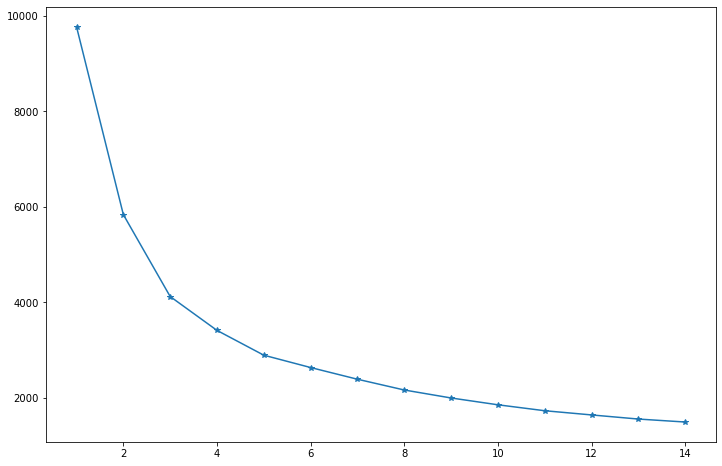

In [39]:
plt.figure(figsize=(12,8))
plt.plot(clusters_df['num_of_clusters'], clusters_df['Cluster_errors'], marker='*')

#optimal number of clusters = 3

In [40]:
#create clusters using Kmean clustering

model = KMeans(n_clusters=3, n_init=15, random_state=2345)
model.fit(RFM)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [41]:
centroids = model.cluster_centers_
centroids

array([[-0.71324762,  1.45967131, -0.59248744],
       [-0.46253231, -0.50123998, -0.53940942],
       [ 0.97626332, -0.35330297,  0.98725663]])

In [42]:
model.labels_

array([2, 0, 2, ..., 2, 0, 0])

In [43]:
RFM['lables'] = model.labels_

In [44]:
RFM

,frequency,recency,monetary_value,lables
customer_id,,,,
1,2.567054,-1.043368,-0.004556,2
2,-1.214537,1.586116,-0.506816,0
3,0.676258,1.021103,0.168050,2
5,0.203559,-0.847786,-0.399822,1
6,-0.269139,0.195315,0.584368,1
...,...,...,...,...
3497,-1.214537,-0.065461,-0.873404,1
3498,0.203559,1.564384,0.077421,0
3499,0.676258,-0.087192,1.224189,2


In [45]:
#mean for recency, frequency, monetary

print(RFM.recency.mean())
print(RFM.frequency.mean())
print(RFM.monetary_value.mean())

4.804832611177013e-18
7.408302196240301e-17
6.815365405924841e-18


<AxesSubplot:>

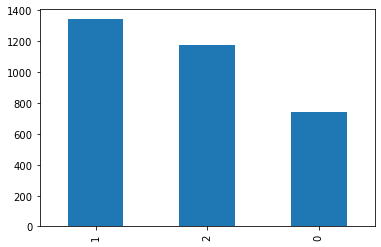

In [46]:
#create bar plots

(RFM.lables.value_counts()).plot(kind='bar')

C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lables', ylabel='count'>

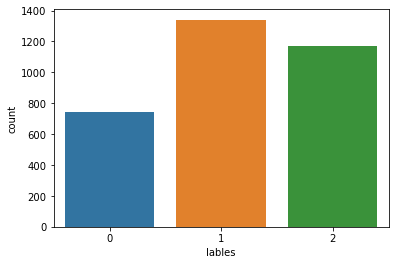

In [47]:
sns.countplot(RFM['lables'])